In [2]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (8,6)})
%load_ext autoreload
%autoreload 2


In [3]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [4]:
dt_ms = 2.0
lag_ms = 25
beta = 0.0
factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
X_series, Y_series = get_data('LMC-BG1', factor)
Y_series = Y_series[dim:]
Xhan = build_hankel(X_series, dim)
X0 = Xhan[:, :-1]
Xp = Xhan[:, 1:]


P_series_N, theta_N, A = eig_companion(X_series, dim, beta=beta)
err_N = mean_square_error(Xp, A @ X0)

P_series_C, theta_C, A, c = eig_companion_Cshift(X_series, dim, beta=beta)
A = np.concatenate((A, np.zeros((A.shape[1],1))), axis=1)
A[-1][-1] = c
X0c = np.vstack((X0, np.ones(X0.shape[1])))
err_C = mean_square_error(Xp, A @ X0c)
print(f'A ERR — NO_SHIFT: {err_N}, C_SHIFT {err_C}')

P_series_N = solve_scale_shift(P_series_N, Y_series)
P_series_C = solve_scale_shift(P_series_C, Y_series)
err_N = mean_square_error(Y_series, P_series_N)
err_C = mean_square_error(Y_series, P_series_C)
print(f'Y ERR — NO_SHIFT: {err_N}, C_SHIFT {err_C}')

theta_N /= theta_N[-1]
theta_C /= theta_C[-1]




A ERR — NO_SHIFT: 0.002375725362144516, C_SHIFT 0.0023152253010822205
Y ERR — NO_SHIFT: 20.5614576081711, C_SHIFT 15.165219077820565


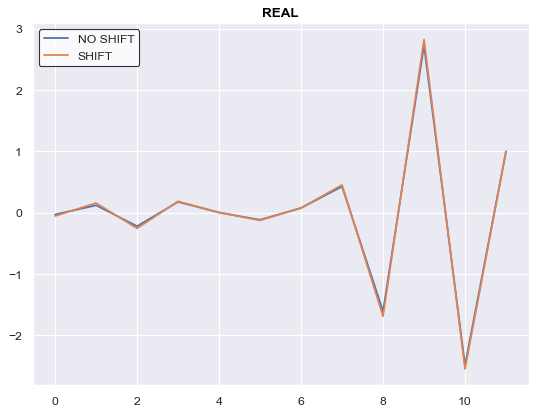

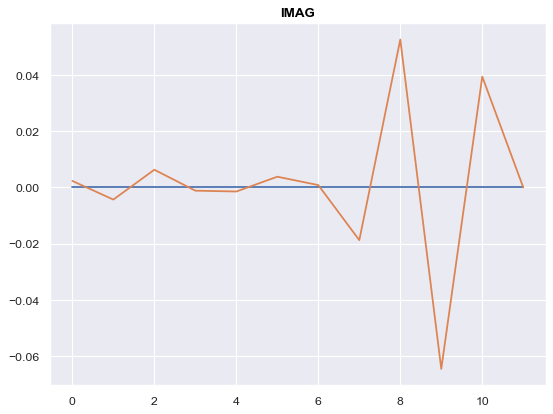

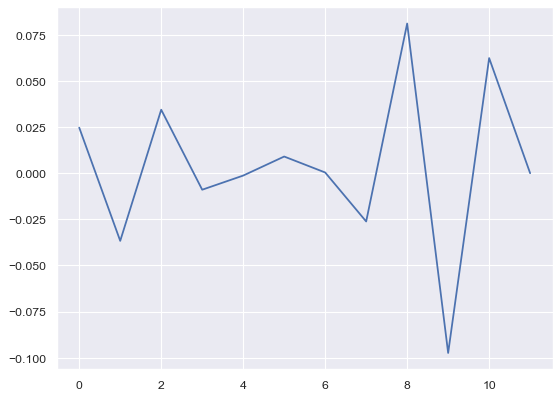

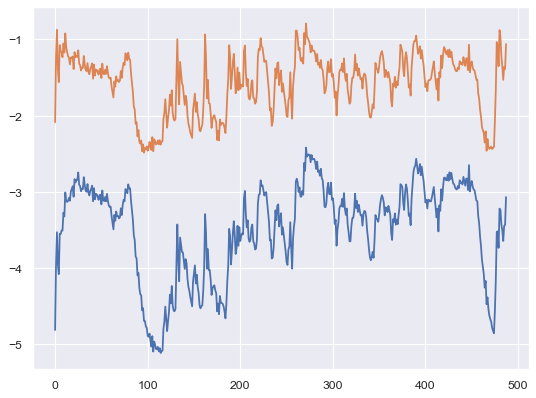

In [5]:
plt.plot(theta_N.real, label='NO SHIFT')
plt.plot(theta_C.real, label='SHIFT')
plt.title("REAL")
plt.legend()
plt.show()


plt.plot(theta_N.imag)
plt.plot(theta_C.imag)
plt.title("IMAG")
plt.show()

plt.plot(theta_N.real - theta_C.real)
plt.show()

plt.plot(theta_N.real @ Xhan)
plt.plot(theta_C.real @ Xhan)
plt.show()

In [42]:
print(theta_N.real @ Xhan[:,0])
print(theta_C.real @ Xhan[:,0])

-4.811307180720917
-2.086792057751211


In [43]:

P_series_N = solve_scale_shift(theta_N.real @ Xhan, Y_series)
P_series_C = solve_scale_shift(theta_C.real @ Xhan, Y_series)

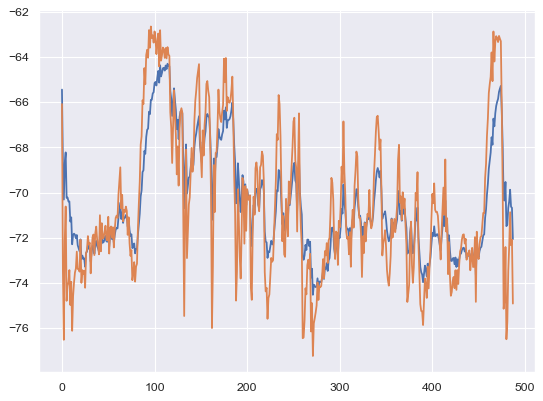

In [44]:
plt.plot(P_series_N)
plt.plot(P_series_C)
plt.show()

In [45]:
diff = np.abs(P_series_N-P_series_C)
sorti = np.argsort(diff)[::-1]

2 -3.5290161880400888 -0.8744030353240646 2.654613152716024
480 -3.2191680713791584 -0.877353035607058 2.3418150357721004
477 -3.52565263365301 -1.0340278434209722 2.491624790232038
162 -3.2913401012558836 -0.9349447969446487 2.356395304311235
132 -3.4274102708061776 -0.9967604429015182 2.4306498279046593
1 -3.942948213157649 -1.2270785513701412 2.715869661787508


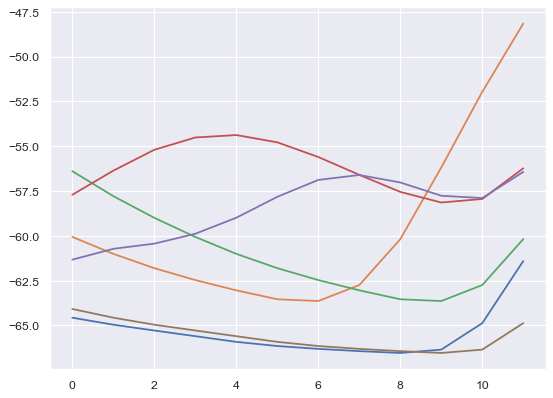

In [51]:
for i in range(6):
    maxi = sorti[i]
    plt.plot(Xhan[:,maxi])
    N = theta_N.real.dot(Xhan[:,maxi])
    C = theta_C.real.dot(Xhan[:,maxi])
    print(maxi, N, C, np.abs(N-C))

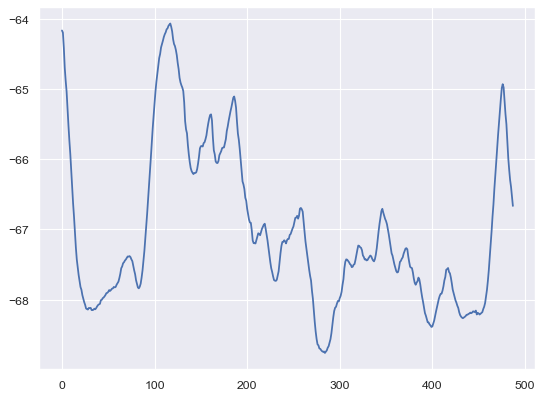

In [9]:
thing = solve_scale_shift( (theta_C.real - theta_N.real) @ Xhan, Y_series - theta_N.real @ Xhan)
plt.plot(thing)
plt.show()

In [10]:
dt_ms = 2.0
lag_ms = 25
factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
X_series, Y_series = get_data('LMC-BG1', factor)
Y_series = Y_series[dim:]
Xhan = build_hankel(X_series, dim)
X0 = Xhan[:, :-1]
Xp = Xhan[:, 1:]

N = X0.shape[1]
window = int(dim * 2)
print(dim, window)
beta = 0
ress_C = []
ress_noC = []
for i in range(0, N-window, 1):

    X0w = X0[:, i:i+window]
    Xpw = Xp[:, i:i+window]

    Xp1 = Xpw[-1]
    X01 = np.vstack((X0w, np.ones(X0w.shape[1])))
    reg_dim = dim + 1

    # matrix for regularization
    lam = beta * np.eye(reg_dim)

    a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)
    # a = scipy.linalg.lstsq(X01.T, Xp1)[0]
    a, c = a[:-1], a[-1:]
    A = np.eye(dim, k=1)
    A[-1] = a
    c_col = np.zeros((A.shape[1],1)) 
    c_col[-1] =c
    A = np.concatenate((A, c_col), axis=1)
    res = np.linalg.norm(Xpw-(A @ X01))
    ress_C.append(res)

    # NO C SHIFT
    lam = beta * np.eye(dim)
    a = (Xp1 @ X0w.T) @ np.linalg.inv((X0w @ X0w.T) + lam)
    A = np.eye(dim, k=1)
    A[-1] = a
    res = np.linalg.norm(Xpw-(A @ X0w))
    ress_noC.append(res)

    # w, vl = scipy.linalg.eig(A, left=True, right=False)


12 24


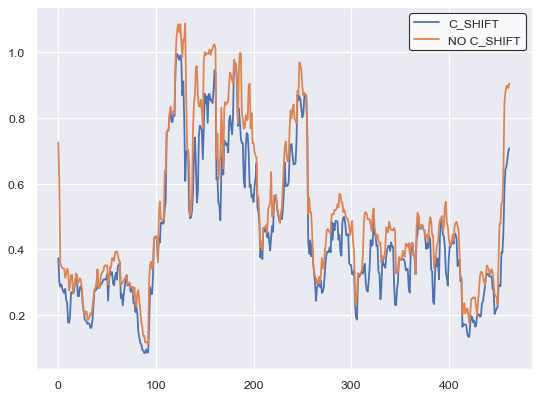

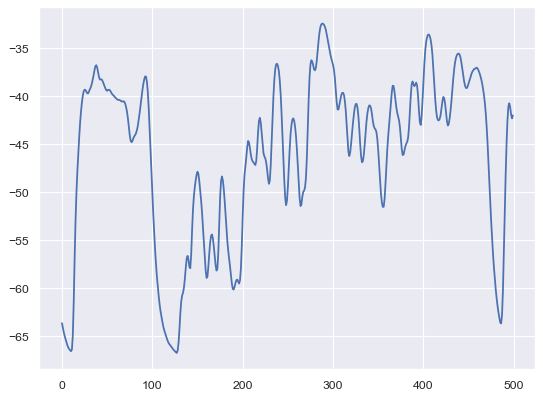

In [11]:
plt.plot(ress_C, label='C_SHIFT')
plt.plot(ress_noC, label='NO C_SHIFT')

plt.legend()
plt.show()

plt.plot(X_series)
plt.show()


In [12]:
ress = np.array(ress_C).copy()
regions = []
num_regions = 5
sort_i = np.argsort(ress)
backset = 5
for i in range(num_regions):
    start_i = sort_i[i]
    end_i = start_i+window
    regions.append(X_series[start_i:end_i])
    sort_i = np.delete(sort_i, np.logical_and(sort_i > start_i-backset, sort_i < end_i))

# [plt.plot(r) for r in regions]

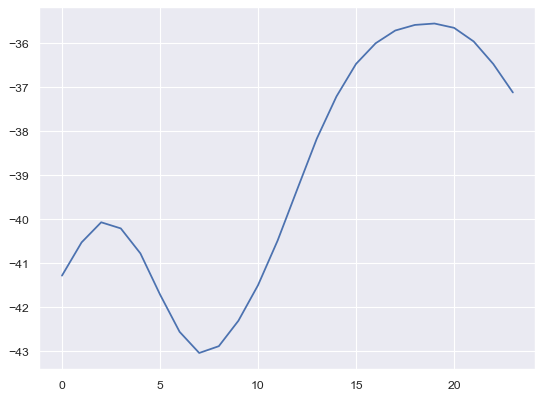

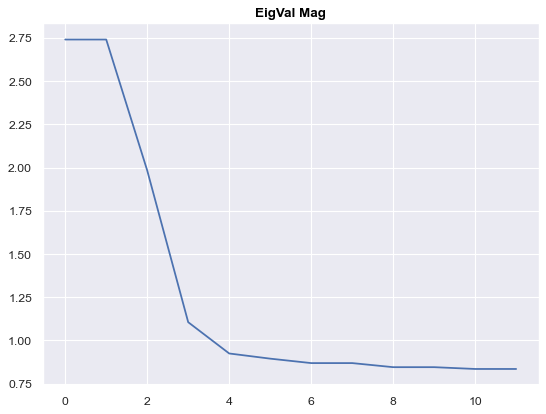

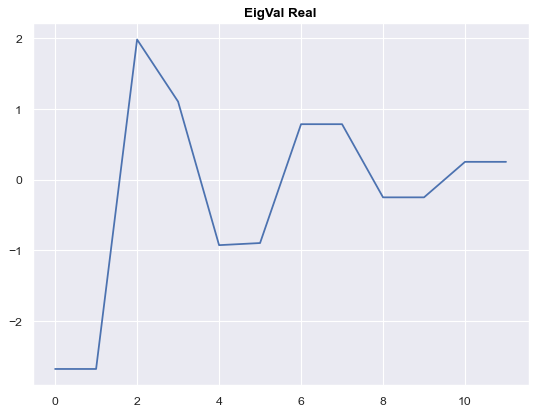

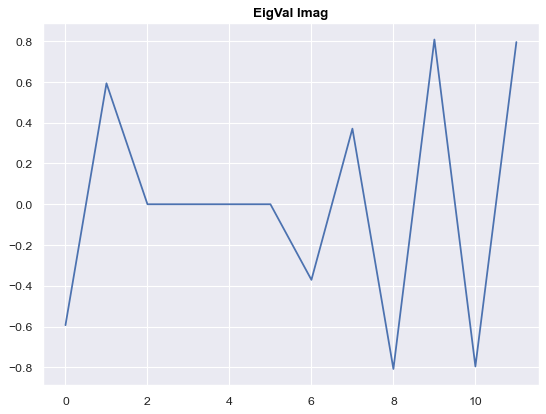

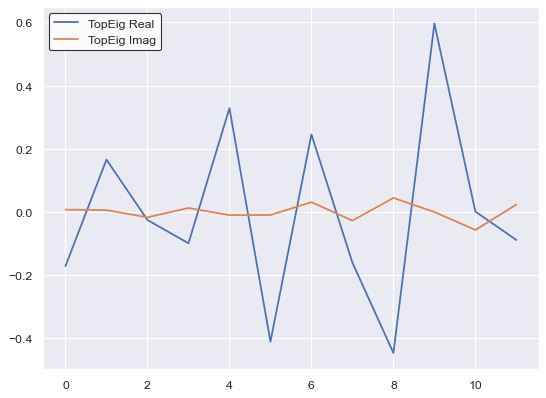

In [13]:


X_series = regions[1]
plt.plot(X_series); plt.show()
theta, P, A= eig_companion(X_series, dim)
w, vl = scipy.linalg.eig(A, left=True, right=False)

sortorder = np.argsort(abs(w))
thetas = vl[:, sortorder][:, ::-1]
w = w[sortorder][::-1]



plt.plot(abs(w)); plt.title('EigVal Mag'); plt.show();
plt.plot(w.real); plt.title('EigVal Real'); plt.show();
plt.plot(w.imag); plt.title('EigVal Imag'); plt.show();
plt.plot(thetas[:, 0].real, label='TopEig Real')
plt.plot(thetas[:, 0].imag, label='TopEig Imag')
plt.legend()
plt.show()



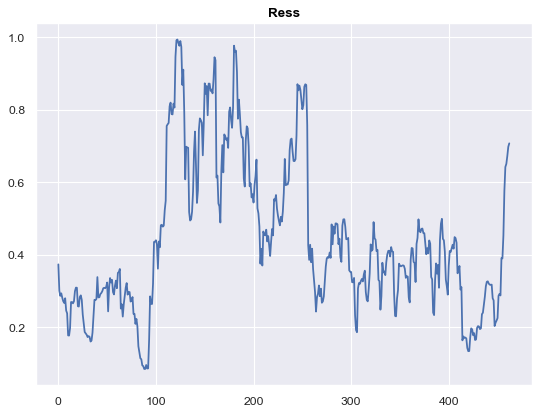

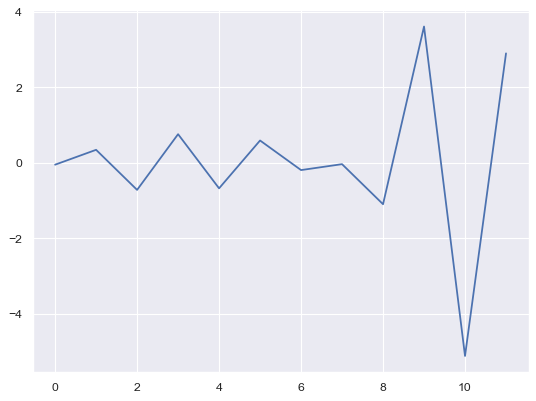

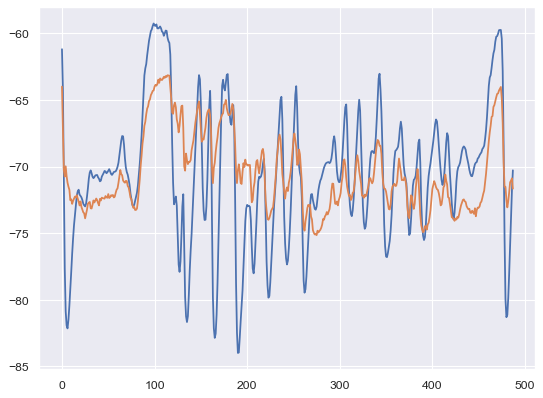

ERR 17.333131357878653


In [14]:
dt_ms = 2.0
lag_ms = 25
factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
X_series, Y_series = get_data('LMC-BG1', factor)
Y_series = Y_series[dim:]
Xhan = build_hankel(X_series, dim)
X0 = Xhan[:, :-1]
Xp = Xhan[:, 1:]

N = X0.shape[1]
window = dim * 2
beta = 0
thetas,ress = [], []
for i in range(0, N-window, 1):

    X0w = X0[:, i:i+window]
    Xpw = Xp[:, i:i+window]

    Xp1 = Xpw[-1]
    X01 = np.vstack((X0w, np.ones(X0w.shape[1])))
    reg_dim = dim + 1

    # matrix for regularization
    lam = beta * np.eye(reg_dim)

    a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)
    # a = scipy.linalg.lstsq(X01.T, Xp1)[0]
    a, c = a[:-1], a[-1:]
    A = np.eye(dim, k=1)
    A[-1] = a
    w, vl = scipy.linalg.eig(A, left=True, right=False)

    c_col = np.zeros((A.shape[1],1)) 
    c_col[-1] =c
    A = np.concatenate((A, c_col), axis=1)
    res = np.linalg.norm(Xpw-(A @ X01))

    sortorder = np.argsort(np.abs(w))
    w = w[sortorder][::-1]
    theta = vl[:, sortorder][:, -1]
    theta /= theta[-1]

    weight = 1/res
    ress.append(res)
    thetas.append(theta.real * weight)


plt.plot(ress)
plt.title('Ress')
plt.show()

theta = np.mean(thetas, axis=0)
plt.plot(theta)
plt.show()

P_series = theta @ Xhan
P_series = solve_scale_shift(P_series, Y_series)
plt.plot(Y_series)
plt.plot(P_series)
plt.show()
print('ERR', mean_square_error(P_series, Y_series))

